<a href="https://colab.research.google.com/github/lwerth/INFO510-public/blob/master/info510_hmwk4_code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [69]:
# ! pip install pymc3 --upgrade
# ! pip install arviz
# ! pip install pandas --upgrade

In [1]:
import numpy as np, scipy as sp, pymc3 as pm, matplotlib.pyplot as plt, pandas as pd, theano, theano.tensor as tt
from scipy import stats
import seaborn as sb
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
import arviz as az

%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.pyplot import *

import theano

## 1

14.1 (a) Fit a linear regression to the logarithms of the radon measurements in Table 7.3, with indicator variables for the three counties and for whether a measurement was recorded on the first floor. Summarize your posterior inferences in nontechnical terms.


> After sampling from the model, we can see that the posterior distribution has a mean of ~1.9 radon levels any house in either of the counties ranging between ~0.5 and ~3.3 levels throughout.

<!-- From the summary table, we can see that any house in either of the counties has a similar level of radon, ~1.9. Although some range between ~0.5 and ~3.3 levels throughout -->

In [77]:
radon = pd.read_csv('/content/drive/My Drive/Fall 2020/info510/hwk4/radon.csv')
radon.head(10)

,county,radon,floor
0,Blue Earth,5.0,0
1,Blue Earth,13.0,0
2,Blue Earth,7.2,0
3,Blue Earth,6.8,0
4,Blue Earth,12.8,0
5,Blue Earth,5.8,1
6,Blue Earth,9.5,0
7,Blue Earth,6.0,0
8,Blue Earth,3.8,0
9,Blue Earth,14.3,1


In [78]:
#transform the data & take the log

#https://nbviewer.jupyter.org/github/fonnesbeck/multilevel_modeling/blob/master/multilevel_modeling.ipynb?create=1

county_names = radon.county.unique()
radon['county_idx'] = OrdinalEncoder(dtype = np.int64).fit_transform(radon[['county']])
radon['log_radon'] = np.log(radon[['radon']])
n_counties = len(radon.county.unique())
n_floor = len(radon.floor.unique())
floor_idx = OrdinalEncoder(dtype = np.int64).fit_transform(radon[['floor']])

print(radon.head())
# print(floor_idx)


       county  radon  floor  county_idx  log_radon
0  Blue Earth    5.0      0           0   1.609438
1  Blue Earth   13.0      0           0   2.564949
2  Blue Earth    7.2      0           0   1.974081
3  Blue Earth    6.8      0           0   1.916923
4  Blue Earth   12.8      0           0   2.549445


### use varying slopes for this!! --- But also ruggedness??

In [79]:

with pm.Model() as logistic_model:
    eps = pm.HalfCauchy('eps', 5)     # Model error

    alpha = pm.Normal('alpha', 0, eps) 
    b_county = pm.Normal('b_county', 0, sd = 1, shape = n_counties)
    b_floor = pm.Normal('b_floor', 0, sd=1, shape = n_floor) 

    mu = alpha + b_county[radon.county_idx] + b_floor[floor_idx]*radon.floor.values

    # Data likelihood
    y = pm.Normal('y', mu = mu, sd=eps, observed=radon.log_radon)


In [80]:
with logistic_model:
    a_trace = pm.sample(2000)    
    a_sum = pm.summary(a_trace)

a_sum

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [b_floor, b_county, alpha, eps]


Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 81 seconds.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
alpha,1.211,0.466,0.296,2.037,0.015,0.011,1025.0,956.0,1025.0,1424.0,1.01
b_county[0],0.744,0.466,-0.110,1.628,0.014,0.010,1033.0,1033.0,1035.0,1518.0,1.01
b_county[1],0.664,0.466,-0.217,1.515,0.015,0.010,1023.0,1023.0,1020.0,1494.0,1.01
b_county[2],0.707,0.466,-0.184,1.542,0.015,0.010,1027.0,1027.0,1026.0,1482.0,1.01
b_floor[0],-0.327,0.051,-0.423,-0.235,0.001,0.001,3507.0,3470.0,3510.0,2390.0,1.00
b_floor[1],-0.322,0.096,-0.510,-0.148,0.002,0.001,2802.0,2636.0,2818.0,2166.0,1.00
eps,0.752,0.013,0.727,0.777,0.000,0.000,2986.0,2986.0,2980.0,2178.0,1.00


In [81]:

with logistic_model:
    ppc = pm.sample_posterior_predictive(
        a_trace, var_names=["y", 'alpha']
    )

In [82]:
ppc['y'].shape

(4000, 41, 41)

/usr/local/lib/python3.6/dist-packages/arviz/data/io_pymc3.py:91: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


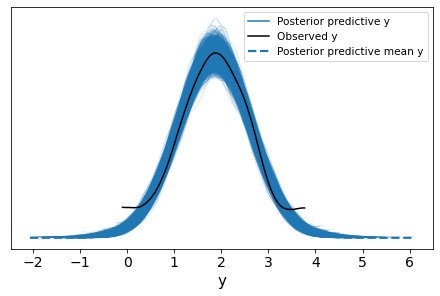

In [83]:
radon_data = az.from_pymc3(a_trace, posterior_predictive=ppc)
az.plot_ppc(radon_data);

In [ ]:

print(np.quantile(radon.log_radon, 0.025))
print(np.quantile(radon.log_radon, 0.975))

0.4054651081081644
3.2809112157876537


/usr/local/lib/python3.6/dist-packages/arviz/data/io_pymc3.py:91: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,
/usr/local/lib/python3.6/dist-packages/arviz/plots/traceplot.py:195: UserWarning: rcParams['plot.max_subplots'] (20) is smaller than the number of variables to plot (1688), generating only 20 plots
  UserWarning,


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f38ddccebe0>,
      dtype=object)

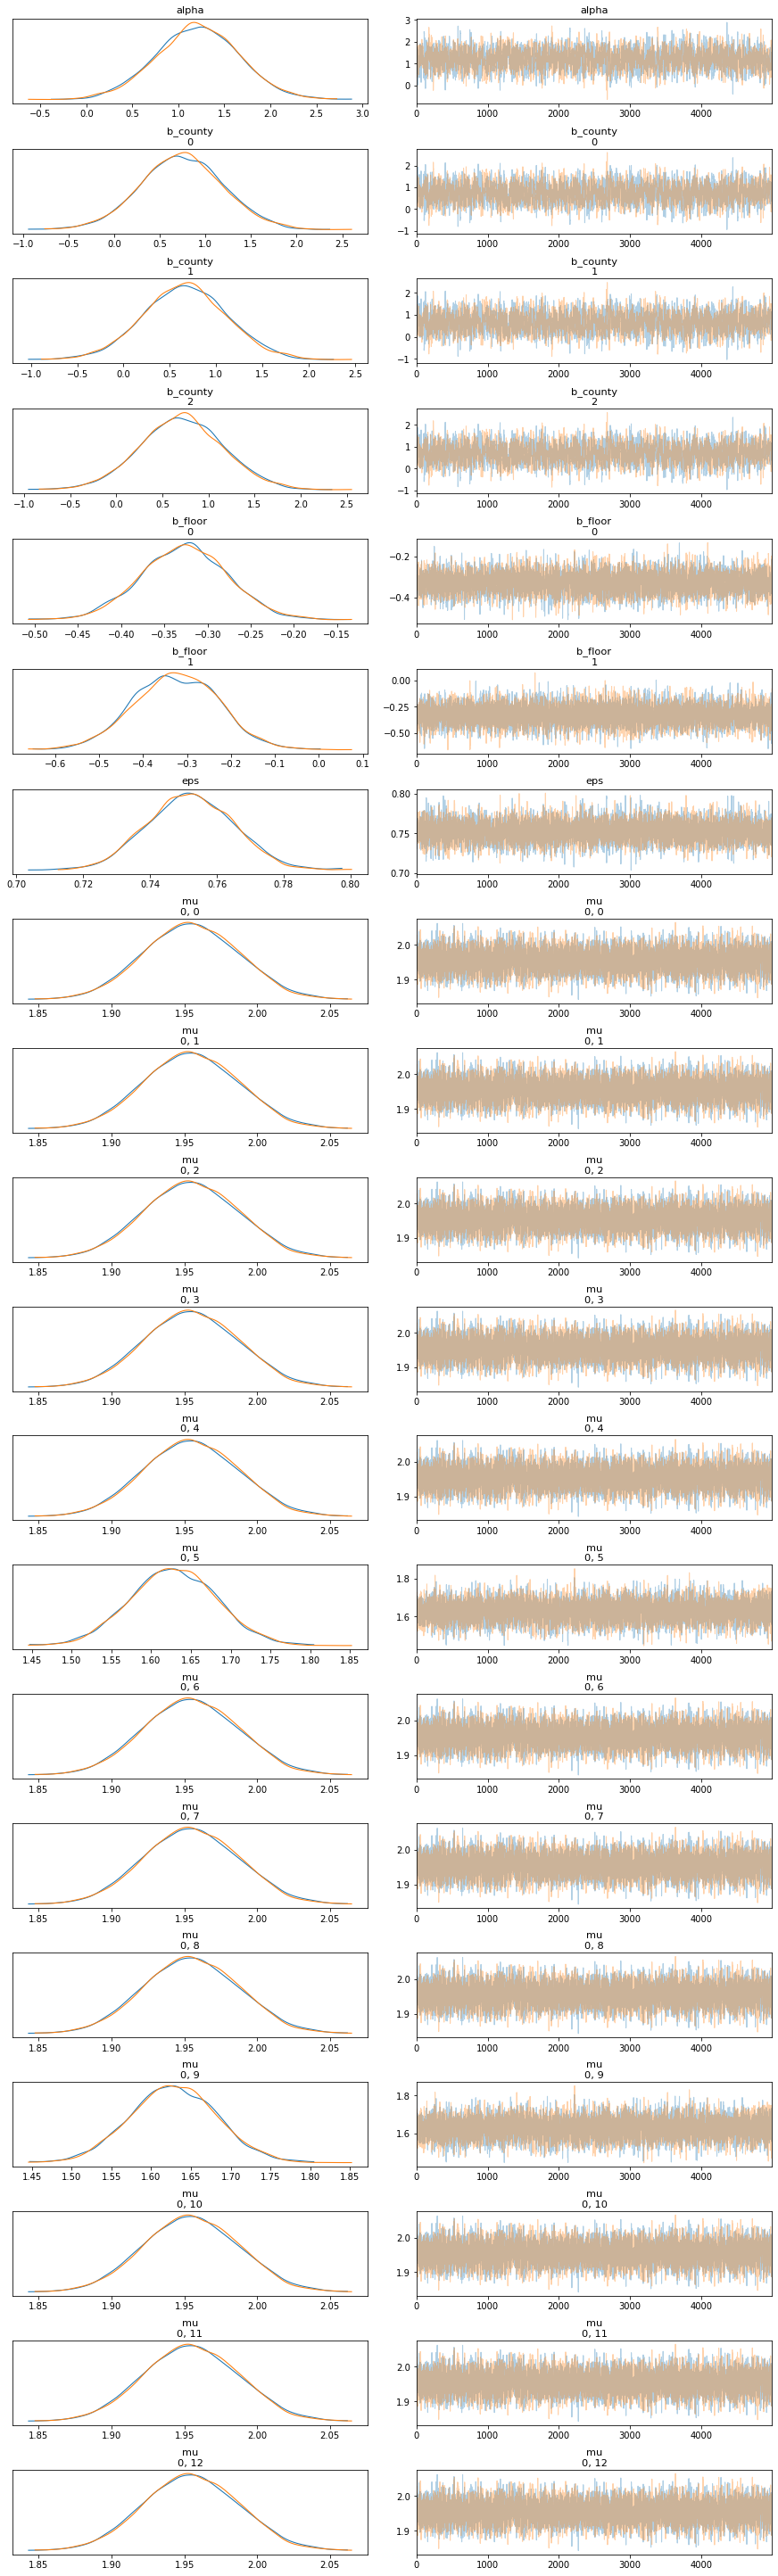

In [ ]:
# pm.forestplot(unpooled_trace, var_names = unpooled_trace.varnames.remove('eps'))

az.plot_trace(a_trace) #var_names=["log_radon", "floor"]);

#lef tside parabola - for each parameter value on the x-axis we get a probability on the y-axis 
#that tells us how likely that parameter value is

## 2
14.1 (b) Suppose another house is sampled at random from Blue Earth County. Sketch the posterior predictive distribution for its radon measurement and give a 95% predictive interval. Express the interval on the original (unlogged) scale. (Hint: you must consider the separate possibilities of basement or first-floor measurement.)


>The 95% predictive interval is ~9.3 based on the unlogged scale of radon measurements.

In [84]:
with pm.Model() as b_model:
    # n_floor = len(radon.floor)
    n_floor = len(radon.floor.unique())
    floor_idx = OrdinalEncoder(dtype = np.int64).fit_transform(radon[['floor']])

    # Priors for parameters
    c_b = pm.Normal('c_b', 0, 0.5, shape = n_floor) #county w/basement
    # c_nb = pm.Normal('c_nb', 0, 0.5) #county w/ no basement
    c = pm.Normal('c', 0, 5, shape = n_counties) #county
    alpha = pm.Normal('alpha', 0, 0.2)
    sigma = pm.Exponential('sigma', 1)

    # Model equation
    mu = alpha + c[radon.county_idx[0]] + c_b[floor_idx[1]]*radon.floor
    
    # mu = alpha + aW[wines['wine'].values] + aJ[wines['judge'].values] # use .values here to avoid annoying theano warnings
    
    # Observation model
    score = pm.Normal('score', mu = mu, sigma = sigma, observed = radon.radon)
    
    # Sampling
    b_trace = pm.sample(5000, target_accept = 0.95)
    b_sumtab = pm.summary(b_trace)

b_sumtab

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [sigma, alpha, c, c_b]


Sampling 2 chains for 1_000 tune and 5_000 draw iterations (2_000 + 10_000 draws total) took 21 seconds.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
c_b[0],-0.074,0.494,-0.972,0.882,0.004,0.006,17597.0,3795.0,17610.0,6791.0,1.0
c_b[1],-0.001,0.491,-0.949,0.900,0.004,0.005,15398.0,4500.0,15398.0,7659.0,1.0
c[0],8.112,1.131,6.064,10.320,0.009,0.007,14791.0,14714.0,14931.0,7491.0,1.0
c[1],0.028,5.028,-9.002,9.674,0.039,0.059,16762.0,3693.0,16756.0,7279.0,1.0
c[2],0.044,5.043,-9.557,9.248,0.040,0.056,15749.0,4071.0,15767.0,7694.0,1.0
alpha,0.010,0.200,-0.363,0.386,0.002,0.002,16249.0,4076.0,16257.0,7021.0,1.0
sigma,7.211,0.753,5.894,8.693,0.006,0.004,15655.0,14651.0,16548.0,7355.0,1.0


In [85]:

with b_model:
    ppc = pm.sample_posterior_predictive(
        b_trace, var_names=['score', 'alpha']
    )

In [86]:
ppc['score'].shape

(10000, 41)

/usr/local/lib/python3.6/dist-packages/arviz/data/io_pymc3.py:91: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,
/usr/local/lib/python3.6/dist-packages/google/colab/_event_manager.py:28: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/usr/local/lib/python3.6/dist-packages/IPython/core/pylabtools.py:125: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


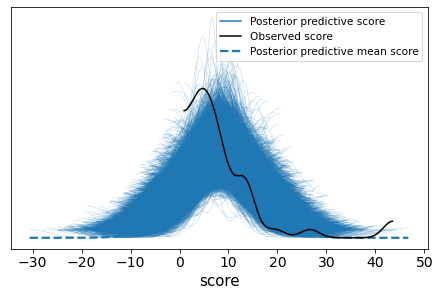

In [87]:
radon_data = az.from_pymc3(b_trace, posterior_predictive=ppc)
az.plot_ppc(radon_data);

In [ ]:
# print(np.quantile(radon_data, 0.025))
# print(np.quantile(radon_data, 0.975))

print(np.quantile(radon.radon, 0.025))
print(np.quantile(radon.radon, 0.95))

1.5
19.5


/usr/local/lib/python3.6/dist-packages/arviz/data/io_pymc3.py:91: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7ff3ee6db828>],
      dtype=object)

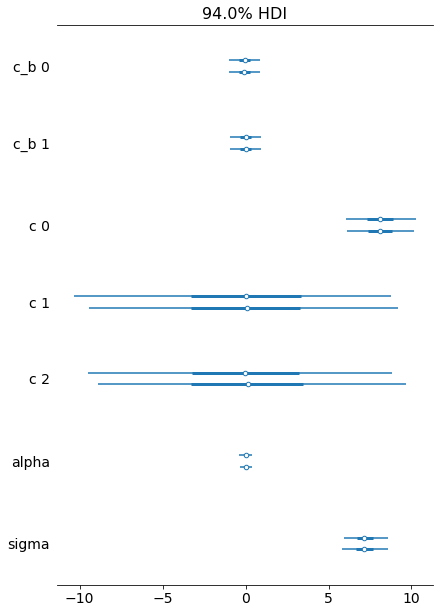

In [ ]:
pm.forestplot(b_trace)

/usr/local/lib/python3.6/dist-packages/arviz/data/io_pymc3.py:91: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f24008672b0>,
      dtype=object)

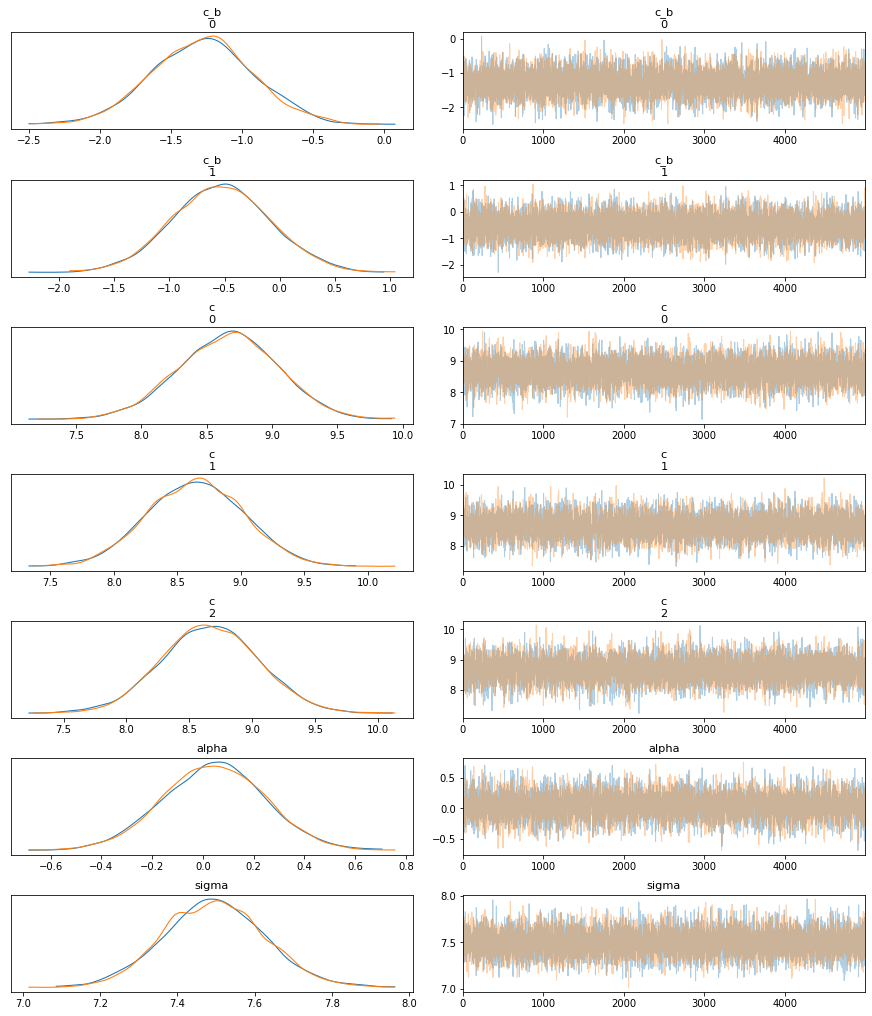

In [ ]:
az.plot_trace(b_trace) #var_names=["log_radon", "floor"]);

#left side parabola - for each parameter value on the x-axis we get a probability on the y-axis 
#that tells us how likely that parameter value is

Regression with many explanatory variables: Table 15.2 displays data from a designed experiment for a chemical process. In using these data to illustrate various approaches to selection and estimation of regression coefficients, Marquardt and Snee (1975) assume a quadratic regression form; that is, a linear relation between the expectation of the untransformed outcome, y, and the variables $x_1, x_2, x_3$, their two-way interactions, $x_1x_2, x_1x_3, x_2x_3$, and their squares, $x_2^{1}, x_2^{2}, x_2^{3}$.

## 3
(a) Fit an ordinary linear regression model (that is, nonhierarchical with a uniform prior distribution on the coefficients), including a constant term and the nine explanatory variables above.

In [2]:
chemical = pd.read_csv('/content/drive/My Drive/Fall 2020/info510/hwk4/chemical.csv')
chemical.head()

chem_blocks = chemical.x1.unique()
chem_idx = OrdinalEncoder(dtype = np.int64).fit_transform(chemical[['x1']])
n_chem = len(chemical.x1.unique())

chemical.head()

,x1,x2,x3,y
0,1300,7.5,0.0120,49.0
1,1300,9.0,0.0120,50.2
2,1300,11.0,0.0115,50.5
3,1300,13.5,0.0130,48.5
4,1300,17.0,0.0135,47.5


In [3]:
#create a data frame with the 9 explanatory variables

variables = chemical.drop('y', axis=1)
variables['x1x2'] = variables.x1.multiply(variables.x2)
variables['x1x3'] = variables.x1.multiply(variables.x3)
variables['x2x3'] = variables.x2.multiply(variables.x3)
variables['x1_2'] = variables.x1**2
variables['x2_2'] = variables.x2**2
variables['x3_2'] = variables.x3**2
variables

#create another dataframe of the 9 explanatory variables and the outcome, y - all standardized
chem_var = variables.join(chemical.y)
chem_var[['y']] = StandardScaler().fit_transform(chem_var[['y']])
chem_var[['x1']] = StandardScaler().fit_transform(chem_var[['x1']])
chem_var[['x2']] = StandardScaler().fit_transform(chem_var[['x2']])
chem_var[['x3']] = StandardScaler().fit_transform(chem_var[['x3']])
chem_var[['x1x2']] = StandardScaler().fit_transform(chem_var[['x1x2']])
chem_var[['x1x3']] = StandardScaler().fit_transform(chem_var[['x1x3']])
chem_var[['x2x3']] = StandardScaler().fit_transform(chem_var[['x2x3']])
chem_var[['x1_2']] = StandardScaler().fit_transform(chem_var[['x1_2']])
chem_var[['x2_2']] = StandardScaler().fit_transform(chem_var[['x2_2']])
chem_var[['x3_2']] = StandardScaler().fit_transform(chem_var[['x3_2']])

n_var = len(chem_var.y.unique())
print(variables)
print(chem_var)


      x1    x2      x3     x1x2    x1x3    x2x3     x1_2    x2_2      x3_2
0   1300   7.5  0.0120   9750.0   15.60  0.0900  1690000   56.25  0.000144
1   1300   9.0  0.0120  11700.0   15.60  0.1080  1690000   81.00  0.000144
2   1300  11.0  0.0115  14300.0   14.95  0.1265  1690000  121.00  0.000132
3   1300  13.5  0.0130  17550.0   16.90  0.1755  1690000  182.25  0.000169
4   1300  17.0  0.0135  22100.0   17.55  0.2295  1690000  289.00  0.000182
5   1300  23.0  0.0120  29900.0   15.60  0.2760  1690000  529.00  0.000144
6   1200   5.3  0.0400   6360.0   48.00  0.2120  1440000   28.09  0.001600
7   1200   7.5  0.0380   9000.0   45.60  0.2850  1440000   56.25  0.001444
8   1200  11.0  0.0320  13200.0   38.40  0.3520  1440000  121.00  0.001024
9   1200  13.5  0.0260  16200.0   31.20  0.3510  1440000  182.25  0.000676
10  1200  17.0  0.0340  20400.0   40.80  0.5780  1440000  289.00  0.001156
11  1200  23.0  0.0410  27600.0   49.20  0.9430  1440000  529.00  0.001681
12  1100   5.3  0.0840   

In [58]:
with pm.Model() as ord_model:
  # parameter proirs
  alpha = pm.Normal('alpha', 0, .2) # for some reason I set the alpha to 1 and it was taking much longer than I needed, hopefully .2 works
  # alpha = pm.Flat('alpha')
  sigma = pm.Flat('sigma')
  # sigma = pm.HalfCouchy('sigma', 1)
  b = pm.Normal('b', 0, .5, shape=9) #use for each explanatory variable - I had this at 1 and it was KILLING my sampling!! 

# Model equation and observation
  mu = pm.Deterministic('mu', alpha + b[0]*chem_var.x1 + b[1]*chem_var.x2 + b[2]*chem_var.x3 + b[3]*chem_var.x1x2 +  b[4]*chem_var.x1x3 + b[5]*chem_var.x2x3 + b[6]*chem_var.x1_2 + b[7]*chem_var.x2_2 + b[8]*chem_var.x3_2)
  y = pm.Normal('y', mu, sigma, observed=chem_var.y) #chem_var.y

In [59]:
#played around with different tune and target acceptance rates
with ord_model:
    trace_1 = pm.sample(2000,  init='advi', cores = 2, tune=2000, target_accept = .95)
    trace_1_sum = pm.summary(trace_1)

trace_1_sum

Auto-assigning NUTS sampler...
Initializing NUTS using advi...


Convergence achieved at 10500
Interrupted at 10,499 [5%]: Average Loss = 4.8095e+05
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [b, sigma, alpha]


Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 128 seconds.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
alpha,-0.000,0.054,-0.102,0.106,0.001,0.001,4649.0,1440.0,4697.0,2180.0,1.0
sigma,0.227,0.055,0.136,0.324,0.001,0.001,1647.0,1632.0,1849.0,1757.0,1.0
b[0],0.412,0.390,-0.309,1.150,0.008,0.006,2591.0,2142.0,2598.0,2199.0,1.0
b[1],0.179,0.389,-0.561,0.877,0.008,0.006,2389.0,1929.0,2389.0,2281.0,1.0
b[2],-0.202,0.417,-0.990,0.548,0.008,0.006,2550.0,2109.0,2548.0,2565.0,1.0
b[3],0.030,0.378,-0.636,0.762,0.008,0.007,2208.0,1653.0,2217.0,2283.0,1.0
b[4],-0.182,0.422,-0.966,0.618,0.008,0.007,3009.0,1853.0,3016.0,2497.0,1.0
b[5],0.227,0.154,-0.066,0.518,0.002,0.002,3989.0,3641.0,4047.0,2438.0,1.0
b[6],0.383,0.383,-0.345,1.084,0.008,0.006,2584.0,2221.0,2588.0,2146.0,1.0
b[7],-0.243,0.263,-0.705,0.290,0.004,0.004,3517.0,2400.0,3568.0,2754.0,1.0


In [70]:

with ord_model:
    ppc = pm.sample_posterior_predictive(
        trace_1, var_names=["y", 'alpha']
    )

In [71]:
ppc['y'].shape

(4000, 16)

/usr/local/lib/python3.6/dist-packages/arviz/data/io_pymc3.py:91: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,
/usr/local/lib/python3.6/dist-packages/google/colab/_event_manager.py:28: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/usr/local/lib/python3.6/dist-packages/IPython/core/pylabtools.py:125: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


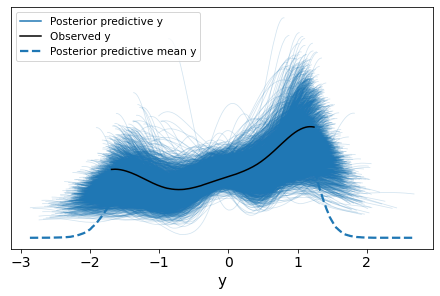

In [72]:
chem_treatment_ord = az.from_pymc3(trace_1, posterior_predictive=ppc)
az.plot_ppc(chem_treatment_ord);

/usr/local/lib/python3.6/dist-packages/arviz/data/io_pymc3.py:91: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,
/usr/local/lib/python3.6/dist-packages/arviz/plots/traceplot.py:195: UserWarning: rcParams['plot.max_subplots'] (20) is smaller than the number of variables to plot (27), generating only 20 plots
  UserWarning,


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f05e2618a20>,
      dtype=object)

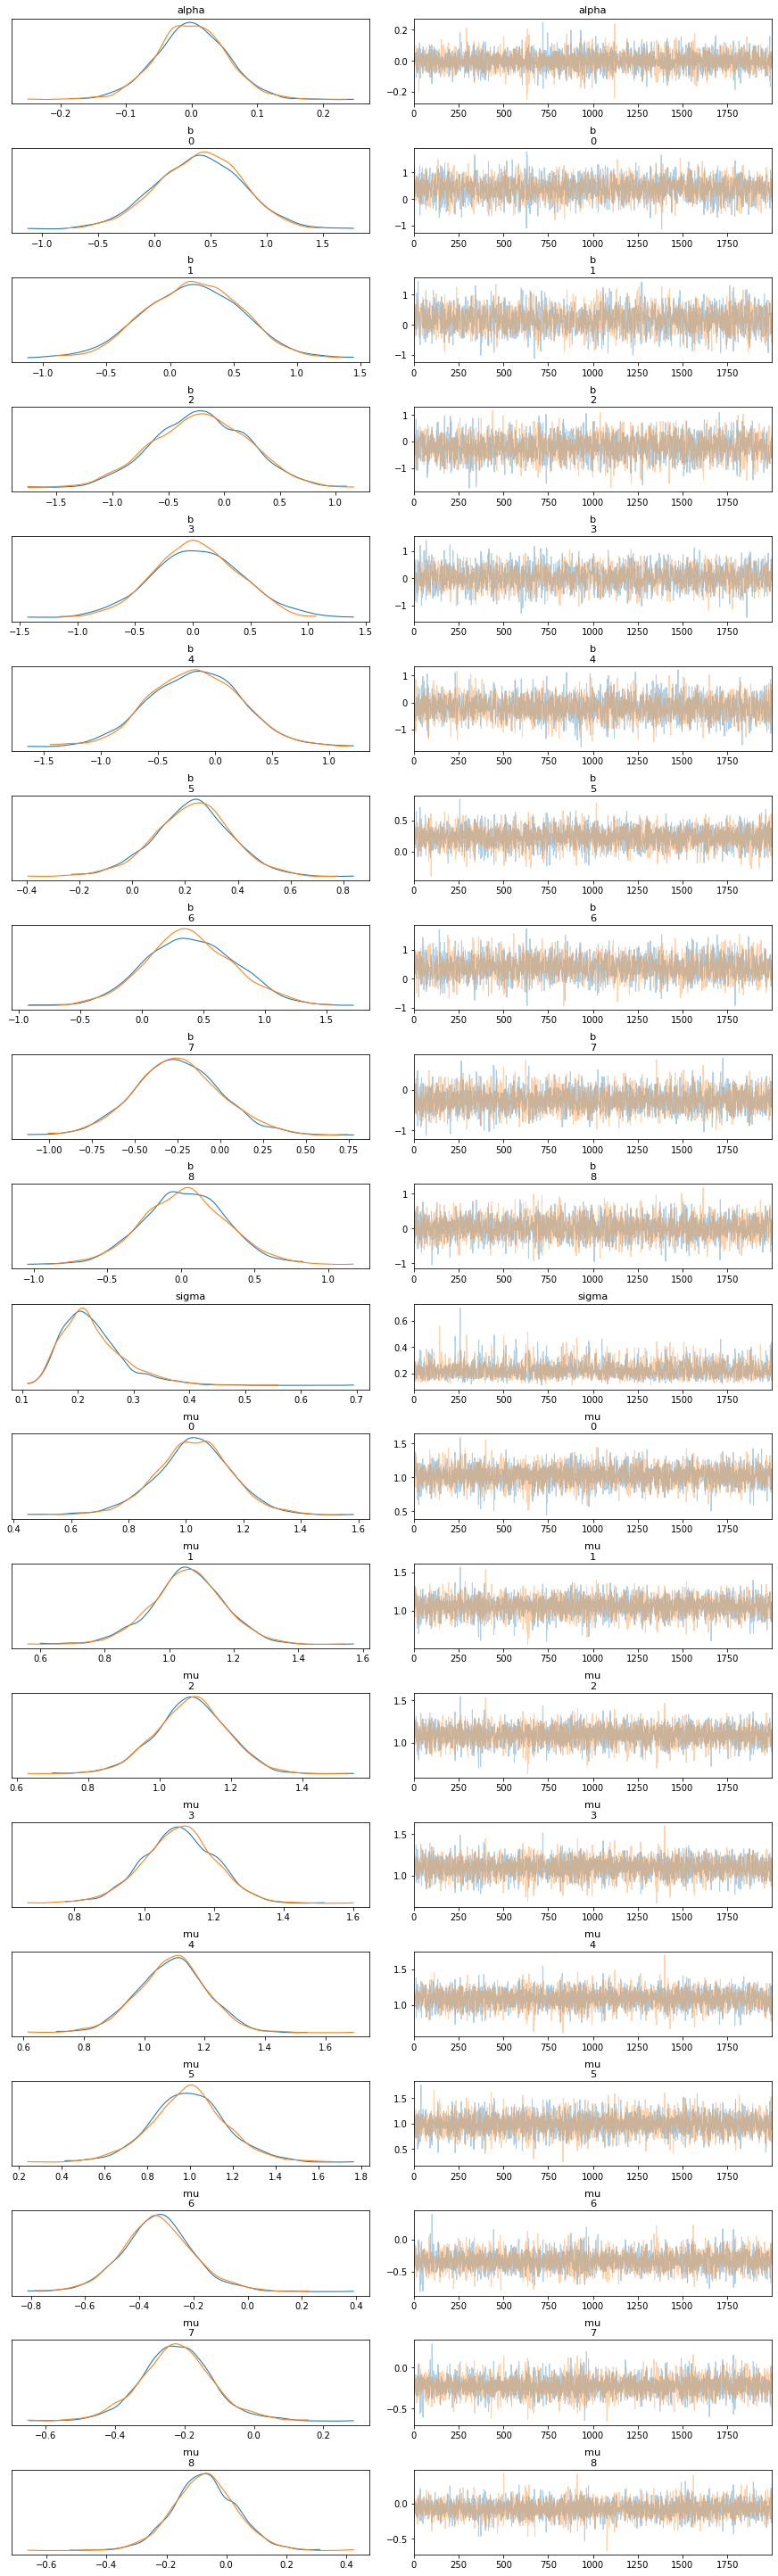

In [52]:
az.plot_trace(trace_1)

## 4
(b) Fit a mixed-effects linear regression model with a uniform prior distribution on the constant term and a shared normal prior distribution on the coefficients of the nine variables above. If you use iterative simulation in your computations, be sure to use multiple sequences and monitor their joint convergence.

## I think we have a winner??

In [116]:
# mu = alpha + b[chem_var.x1] + b[chem_var.x2] + b[chem_var.x3] + b[chem_var.x1x2] + b[chem_var.x1x3] + b[chem_var.x2x3] + b[chem_var.x1_2] + b[chem_var.x2_2] + b[chem_var.x3_2]
#using 8 schools example

with pm.Model() as model_multi:
  a = pm.Normal('a', 0, .2)
  sigma = pm.HalfCauchy('sigma', 5)
  tau = pm.HalfCauchy('tau', 5)
  eta = pm.Normal('eta', 0, 1)
  # b = pm.Normal('b', eta, tau, shape = n_var)

  # b_x1 = pm.Normal('b_x1', 0, 1, shape = n_var)
  # b_x2 = pm.Normal('b_x2', 0, 1, shape = n_var)
  # b_x3 = pm.Normal('b_x3', 0, 1, shape = n_var)
  # b_x1x2 = pm.Normal('b_x1x2', 0, 1, shape = n_var)
  # b_x1x3 = pm.Normal('b_x1x3', 0, 1, shape = n_var)
  # b_x2x3 = pm.Normal('b_x2x3', 0, 1, shape = n_var)
  # b_x1_2 = pm.Normal('b_x1_2', 0, 1, shape = n_var)
  # b_x2_2 = pm.Normal('b_x2_2', 0, 1, shape = n_var)
  # b_x3_2 = pm.Normal('b_x3_2', 0, 1, shape = n_var)

  b_x1 = pm.Normal('b_x1', 0, tau, shape = n_var)
  b_x2 = pm.Normal('b_x2', 0, tau, shape = n_var)
  b_x3 = pm.Normal('b_x3', 0, tau, shape = n_var)
  b_x1x2 = pm.Normal('b_x1x2', 0, tau, shape = n_var)
  b_x1x3 = pm.Normal('b_x1x3', 0, tau, shape = n_var)
  b_x2x3 = pm.Normal('b_x2x3', 0, tau, shape = n_var)
  b_x1_2 = pm.Normal('b_x1_2', 0, tau, shape = n_var)
  b_x2_2 = pm.Normal('b_x2_2', 0, tau, shape = n_var)
  b_x3_2 = pm.Normal('b_x3_2', 0, tau, shape = n_var)

  
  # mu = pm.Deterministic('mu', a + b[0]*chem_var.x1 + b[1]*chem_var.x2 + b[2]*chem_var.x3 + b[3]*chem_var.x1x2 +  b[4]*chem_var.x1x3 + b[5]*chem_var.x2x3 + b[6]*chem_var.x1_2 + b[7]*chem_var.x2_2 + b[8]*chem_var.x3_2)

  mu = pm.Deterministic('mu', a + tt.dot(b_x1, chem_var.x1) + tt.dot(b_x2, chem_var.x2) + tt.dot(b_x3, chem_var.x3) + tt.dot(b_x1x2, chem_var.x1x2) + tt.dot(b_x1x3, chem_var.x1x3) + tt.dot(b_x2x3, chem_var.x2x3) +tt.dot(b_x1_2, chem_var['x1_2']) +tt.dot(b_x2_2, chem_var['x2_2']) + tt.dot(b_x3_2, chem_var['x3_2']))
  y = pm.Normal('y', mu=mu, sigma=sigma, observed = chem_var.y)

  trace_m = pm.sample(2000,  init='advi', core = 2, tune=3000, target_accept = .98)
  trace_m_sum = pm.summary(trace_m)

trace_m_sum


Auto-assigning NUTS sampler...
Initializing NUTS using advi...


Convergence achieved at 15500
Interrupted at 15,499 [7%]: Average Loss = 114.99
Sequential sampling (2 chains in 1 job)
NUTS: [b_x3_2, b_x2_2, b_x1_2, b_x2x3, b_x1x3, b_x1x2, b_x3, b_x2, b_x1, eta, tau, sigma, a]


Sampling 2 chains for 3_000 tune and 2_000 draw iterations (6_000 + 4_000 draws total) took 648 seconds.
The rhat statistic is larger than 1.2 for some parameters.
The estimated number of effective samples is smaller than 200 for some parameters.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
a,-0.021,0.193,-0.370,0.352,0.020,0.014,90.0,90.0,90.0,252.0,1.04
eta,-0.160,1.084,-2.178,1.870,0.323,0.235,11.0,11.0,13.0,16.0,1.12
b_x1[0],-0.001,0.258,-0.384,0.288,0.003,0.036,7331.0,26.0,6730.0,20.0,1.09
b_x1[1],0.002,0.266,-0.381,0.325,0.003,0.040,8320.0,23.0,8315.0,22.0,1.08
b_x1[2],0.001,0.233,-0.356,0.386,0.003,0.036,8162.0,21.0,7137.0,19.0,1.11
...,...,...,...,...,...,...,...,...,...,...,...
b_x3_2[14],0.008,0.248,-0.342,0.329,0.004,0.035,3456.0,26.0,3811.0,17.0,1.10
b_x3_2[15],0.003,0.275,-0.401,0.376,0.003,0.040,7265.0,24.0,6734.0,20.0,1.10
sigma,1.101,0.214,0.751,1.524,0.021,0.015,101.0,101.0,106.0,198.0,1.01
tau,0.158,0.208,0.053,0.671,0.087,0.065,6.0,6.0,5.0,12.0,1.33


In [117]:

with model_multi:
    ppc = pm.sample_posterior_predictive(trace_m, var_names=["y", 'a'])

In [118]:
ppc['y'].shape

(4000, 16)

/usr/local/lib/python3.6/dist-packages/arviz/data/io_pymc3.py:91: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,
/usr/local/lib/python3.6/dist-packages/google/colab/_event_manager.py:28: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)


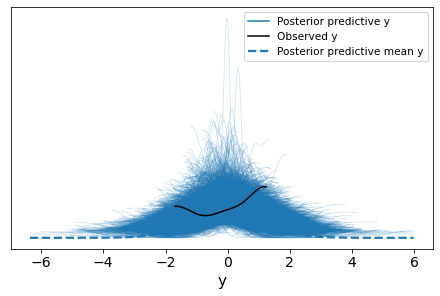

In [119]:
chem_treatment_mult = az.from_pymc3(trace_m, posterior_predictive=ppc)
az.plot_ppc(chem_treatment_mult);

/usr/local/lib/python3.6/dist-packages/arviz/data/io_pymc3.py:91: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,
/usr/local/lib/python3.6/dist-packages/arviz/plots/traceplot.py:195: UserWarning: rcParams['plot.max_subplots'] (20) is smaller than the number of variables to plot (149), generating only 20 plots
  UserWarning,


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f709026c748>,
      dtype=object)

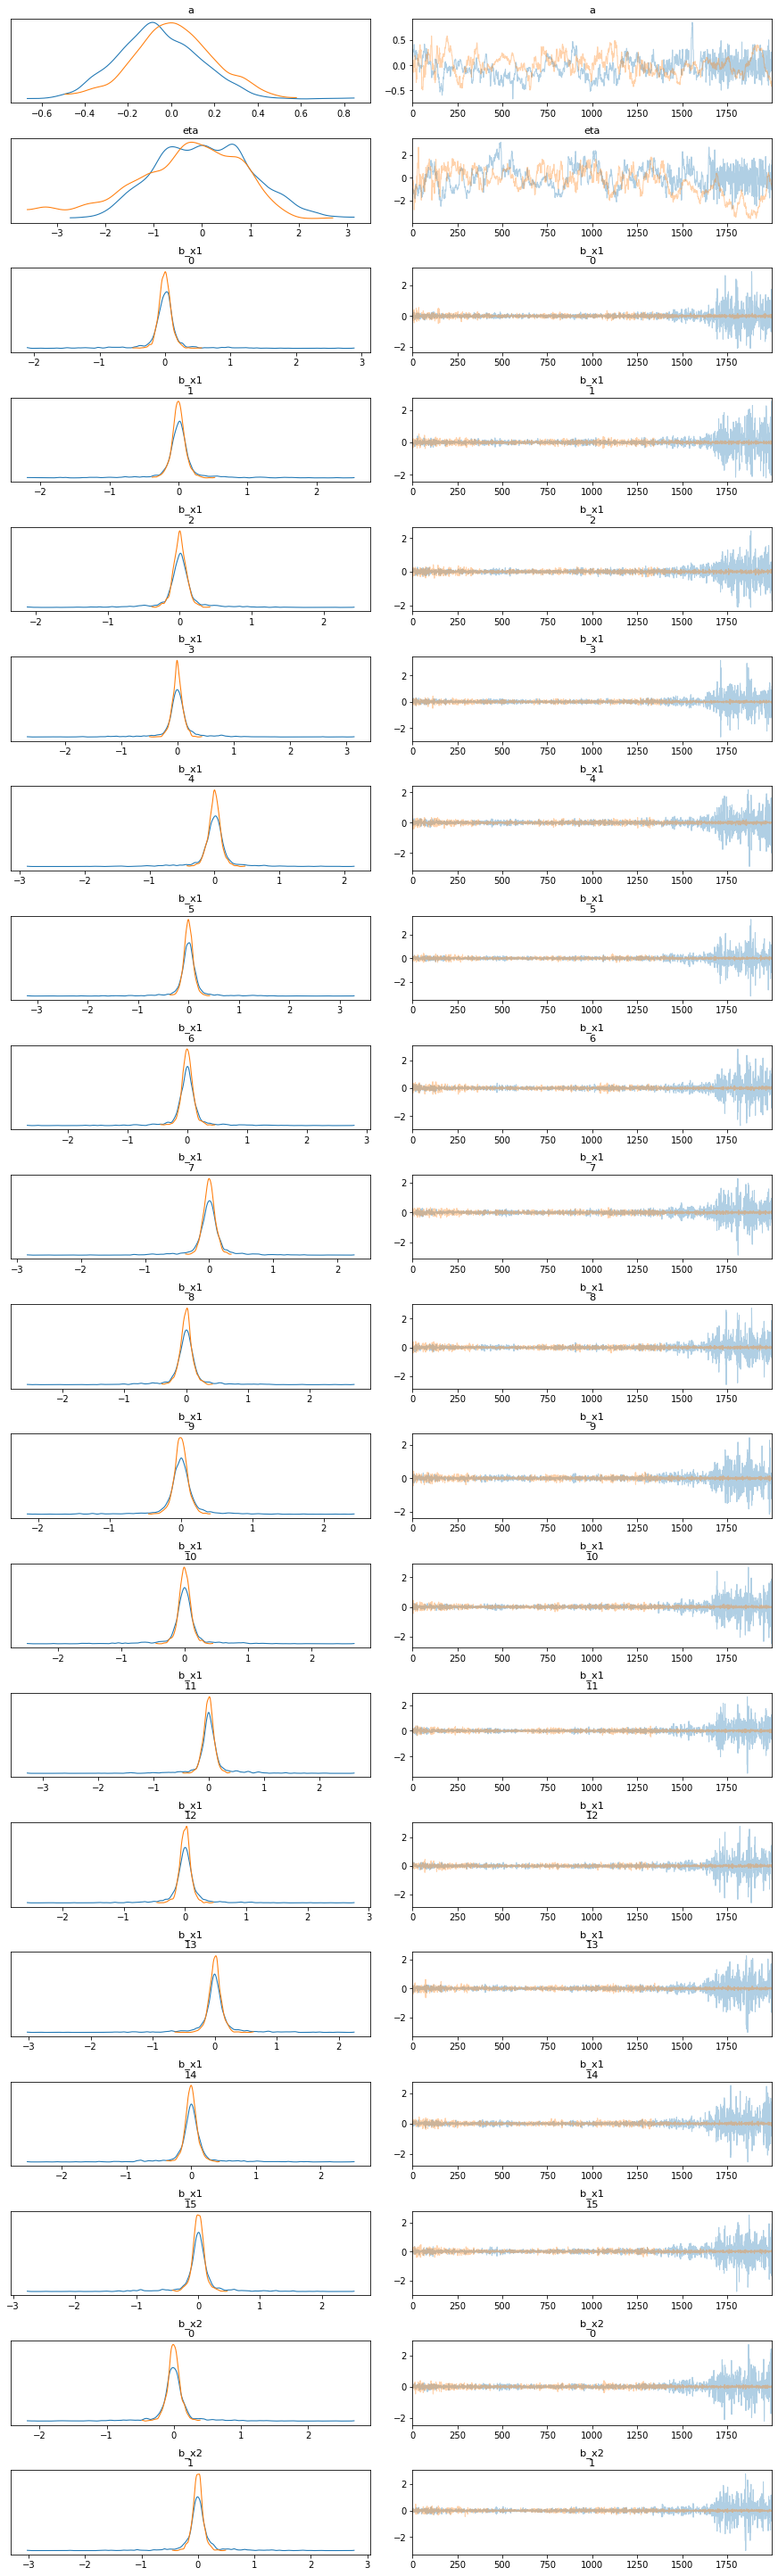

In [120]:
az.plot_trace(trace_m)

More tries

In [122]:
with pm.Model() as model_multi_2:
  a = pm.Normal('a', 0, .2)
  sigma = pm.HalfCauchy('sigma', 5)
  tau = pm.HalfCauchy('tau', 5)
  eta = pm.Normal('eta', 0, 1)
  b = pm.Normal('b', eta, tau, shape = n_var)

  mu = pm.Deterministic('mu', a + b[0]*chem_var.x1 + b[1]*chem_var.x2 + b[2]*chem_var.x3 + b[3]*chem_var.x1x2 +  b[4]*chem_var.x1x3 + b[5]*chem_var.x2x3 + b[6]*chem_var.x1_2 + b[7]*chem_var.x2_2 + b[8]*chem_var.x3_2)

  y = pm.Normal('y', mu=mu, sigma=sigma, observed = chem_var.y)

  trace_m2 = pm.sample(2000,  init='advi', tune=3000, target_accept = .98)
  trace_m2_sum = pm.summary(trace_m2)

trace_m2_sum

Auto-assigning NUTS sampler...
Initializing NUTS using advi...


Convergence achieved at 8900
Interrupted at 8,899 [4%]: Average Loss = 53.179
Sequential sampling (2 chains in 1 job)
NUTS: [b, eta, tau, sigma, a]


Sampling 2 chains for 3_000 tune and 2_000 draw iterations (6_000 + 4_000 draws total) took 257 seconds.
The number of effective samples is smaller than 10% for some parameters.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
a,-0.000,0.057,-0.102,0.108,0.001,0.001,5551.0,1286.0,5552.0,2304.0,1.00
eta,0.073,0.195,-0.308,0.428,0.003,0.006,3746.0,591.0,3570.0,1447.0,1.00
b[0],0.421,0.440,-0.344,1.280,0.010,0.013,1957.0,554.0,2058.0,1054.0,1.00
b[1],0.210,0.484,-0.557,1.135,0.019,0.017,682.0,404.0,1534.0,812.0,1.00
b[2],-0.167,0.486,-1.004,0.788,0.010,0.014,2198.0,623.0,2259.0,1225.0,1.00
b[3],-0.006,0.469,-0.861,0.766,0.017,0.015,736.0,462.0,1460.0,744.0,1.00
b[4],-0.136,0.461,-1.032,0.720,0.010,0.012,2057.0,682.0,2194.0,1142.0,1.00
b[5],0.202,0.162,-0.111,0.506,0.003,0.002,2838.0,2222.0,2946.0,2421.0,1.00
b[6],0.397,0.420,-0.342,1.167,0.009,0.009,2077.0,1015.0,2109.0,1146.0,1.00
b[7],-0.224,0.262,-0.706,0.286,0.005,0.004,2883.0,1791.0,2887.0,2596.0,1.00


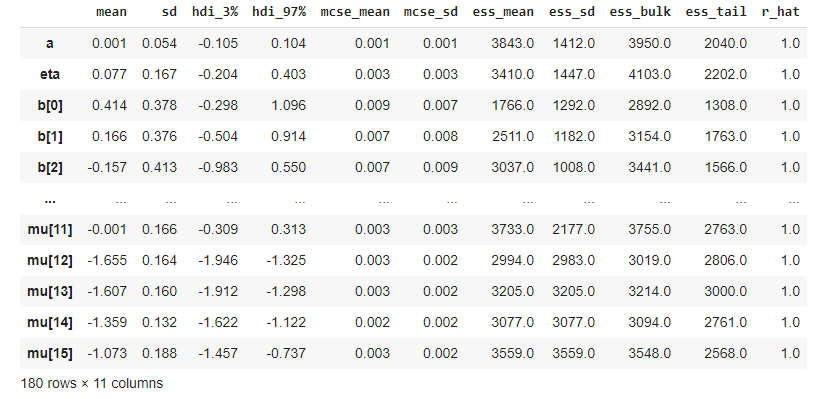

In [123]:

with model_multi_2:
    ppc = pm.sample_posterior_predictive(trace_m2, var_names=["y", 'a'])

In [124]:
ppc['y'].shape

(4000, 16)

/usr/local/lib/python3.6/dist-packages/arviz/data/io_pymc3.py:91: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,
/usr/local/lib/python3.6/dist-packages/google/colab/_event_manager.py:28: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/usr/local/lib/python3.6/dist-packages/IPython/core/pylabtools.py:125: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


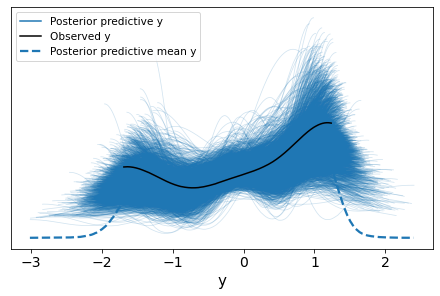

In [125]:
chem_treatment_mult2 = az.from_pymc3(trace_m2, posterior_predictive=ppc)
az.plot_ppc(chem_treatment_mult2);

##5
Discuss the differences between the inferences in (a) and (b). Interpret the differences in terms of the hierarchical variance parameter. Do you agree with Marquardt and Snee that the inferences from (a) are unacceptable?

(a), the ordinary linear regression model ignores the affects each treatment has on each other and treats them as 16 independent instead of 3 sets of temperature variables with about 5 observations in each. Because each treatment is seen as indepentent, the model is prone to overfitting. Using a hierarchcal variance parameter allows correlation within the explanatory variables, and is less prone to positive extremes (overfitting). Hierarchcal variance also shows different components of variability for each temperature which is indicative of stronger reliability. 

## 6
(d) Repeat (a), but with a t4 prior distribution on the nine variables.

### Sample_T

In [6]:
with pm.Model() as t_model:
  # parameter proirs
  alpha = pm.Normal('alpha', 0, .2) # for some reason I set the alpha to 1 and it was taking much longer than I needed, hopefully .2 works
  sigma = pm.Exponential('sigma', 1)
  v = pm.Exponential('ν_minus_one', 1/29) + 1
  b = pm.StudentT('b', nu=v, sigma=sigma, sd=.5, shape=9) #use for each explanatory variable - I had this at 1 and it was KILLING my sampling!! 

# Model equation and observation
  mu = pm.Deterministic('mu', alpha + b[0]*chem_var.x1 + b[1]*chem_var.x2 + b[2]*chem_var.x3 + b[3]*chem_var.x1x2 +  b[4]*chem_var.x1x3 + b[5]*chem_var.x2x3 + b[6]*chem_var.x1_2 + b[7]*chem_var.x2_2 + b[8]*chem_var.x3_2)
  y = pm.Normal('y', mu, sigma, observed=chem_var.y) #chem_var.y


In [7]:
with t_model:
    trace_t = pm.sample(2000,  init='advi', cores = 2, tune=2000, target_accept = .95)
    trace_t_sum = pm.summary(trace_t)

trace_t_sum

Auto-assigning NUTS sampler...
Initializing NUTS using advi...


Convergence achieved at 8100
Interrupted at 8,099 [4%]: Average Loss = 64.785
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [b, ν_minus_one, sigma, alpha]


Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 129 seconds.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
alpha,-0.001,0.054,-0.100,0.104,0.001,0.001,4110.0,1512.0,4124.0,2425.0,1.0
b[0],0.419,0.407,-0.345,1.174,0.009,0.007,2076.0,1948.0,2079.0,1992.0,1.0
b[1],0.177,0.390,-0.556,0.869,0.008,0.007,2187.0,1650.0,2216.0,1735.0,1.0
b[2],-0.191,0.455,-1.050,0.637,0.010,0.008,1983.0,1627.0,2009.0,1950.0,1.0
b[3],0.030,0.384,-0.710,0.721,0.008,0.006,2231.0,1827.0,2220.0,2349.0,1.0
b[4],-0.186,0.422,-0.968,0.629,0.010,0.008,1929.0,1355.0,1990.0,1863.0,1.0
b[5],0.233,0.153,-0.061,0.509,0.003,0.002,3717.0,3266.0,3785.0,2693.0,1.0
b[6],0.383,0.388,-0.326,1.116,0.008,0.006,2454.0,2263.0,2456.0,2374.0,1.0
b[7],-0.245,0.265,-0.760,0.242,0.005,0.004,3247.0,2715.0,3262.0,2488.0,1.0
b[8],0.024,0.290,-0.476,0.595,0.006,0.005,2686.0,1833.0,2704.0,2098.0,1.0


In [22]:

with t_model:
    ppc = pm.sample_posterior_predictive(
        trace_t, var_names=["y", 'alpha']
    )

In [23]:
ppc['y'].shape

(4000, 16)

/usr/local/lib/python3.6/dist-packages/arviz/data/io_pymc3.py:91: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


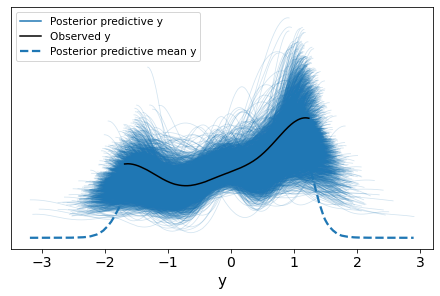

In [25]:
chem_treatment_t = az.from_pymc3(trace_t, posterior_predictive=ppc)
az.plot_ppc(chem_treatment_t);

/usr/local/lib/python3.6/dist-packages/arviz/data/io_pymc3.py:91: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,
/usr/local/lib/python3.6/dist-packages/arviz/plots/traceplot.py:195: UserWarning: rcParams['plot.max_subplots'] (20) is smaller than the number of variables to plot (28), generating only 20 plots
  UserWarning,


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f70b08ad898>,
      dtype=object)

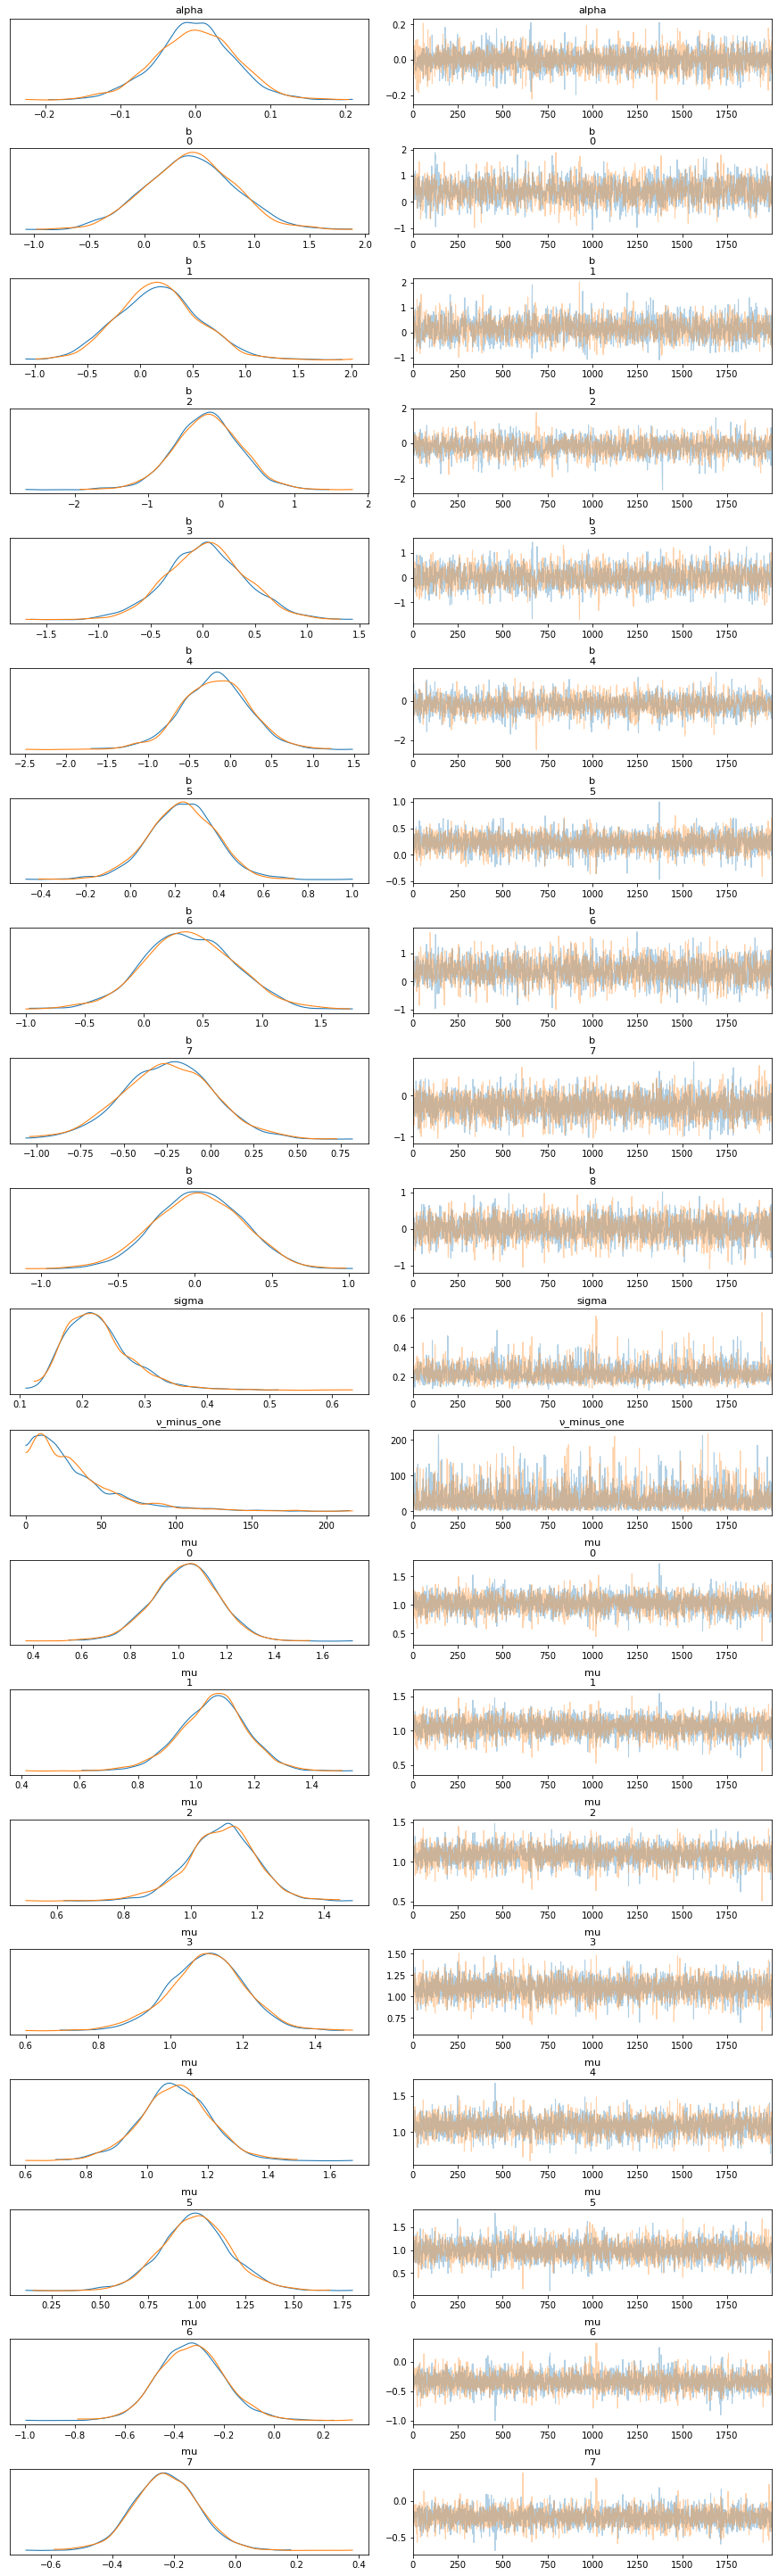

In [8]:
az.plot_trace(trace_t)

#Extra

In [ ]:
with pm.Model() as pooled:
  a = pm.Normal('a', 0, .2)
  beta = pm.Normal('beta', 0, 1)
  tau = pm.Flat('tau')
  sigma = HalfCauchy('sigma', 5)

  





    b_x
  b_xx
  b_x_2
  sigma = pm.HalfCauchy('sigma', 5)
  beta = pm.Normal('beta', .3)

  mu = alpha + tau*chem_var.y + 

In [47]:
#schools example
with pm.Model() as hierarchical_model:
    # Hyperparameters
    eta = pm.Normal('eta', 0, 1)
    tau = pm.HalfCauchy('tau', 5)
    sigma = pm.Exponential('sigma', 1)
    b = pm.Normal('b', eta, tau, shape = 9)
    m = pm.Normal('m', mu = 0, sigma = 5)
    
    # Parameter vector
    # mu = alpha + b[0]*chem_var.x1 + b[1]*chem_var.x2 + b[2]*chem_var.x3 + b[3]*chem_var.x1x2 +  b[4]*chem_var.x1x3 + b[5]*chem_var.x2x3 + b[6]*chem_var.x1_2 + b[7]*chem_var.x2_2 + b[8]*chem_var.x3_2
    
    theta = pm.Deterministic('theta', eta + b * eta)
    #theta = pm.Normal('theta', mu = m, sigma = tau, shape = 8)
    
    # Data likelihood
    y_obs = pm.Normal('y_obs', mu = theta, sigma = sigma, observed = chem_var.y)

    trace_hm = pm.sample(2000, cores = 3, tune=4000, target_accept = .95)
    trace_hm_sum = pm.summary(trace_hm)

trace_hm_sum


#   alpha = pm.Normal('alpha', 0, .2) # for some reason I set the alpha to 1 and it was taking much longer than I needed, hopefully .2 works
#   sigma = pm.Exponential('sigma', 1)

#   b = pm.Normal('b', 0, .5, shape=9) #use for each explanatory variable - I had this at 1 and it was KILLING my sampling!! 

# # Model equation and observation
#   mu = pm.Deterministic('mu', alpha + b[0]*chem_var.x1 + b[1]*chem_var.x2 + b[2]*chem_var.x3 + b[3]*chem_var.x1x2 +  b[4]*chem_var.x1x3 + b[5]*chem_var.x2x3 + b[6]*chem_var.x1_2 + b[7]*chem_var.x2_2 + b[8]*chem_var.x3_2)
#   y = pm.Normal('y', mu, sigma, observed=chem_var.y) #chem_var.y

ValueError: ignored

/usr/local/lib/python3.6/dist-packages/arviz/data/io_pymc3.py:91: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f05dc156fd0>,
      dtype=object)

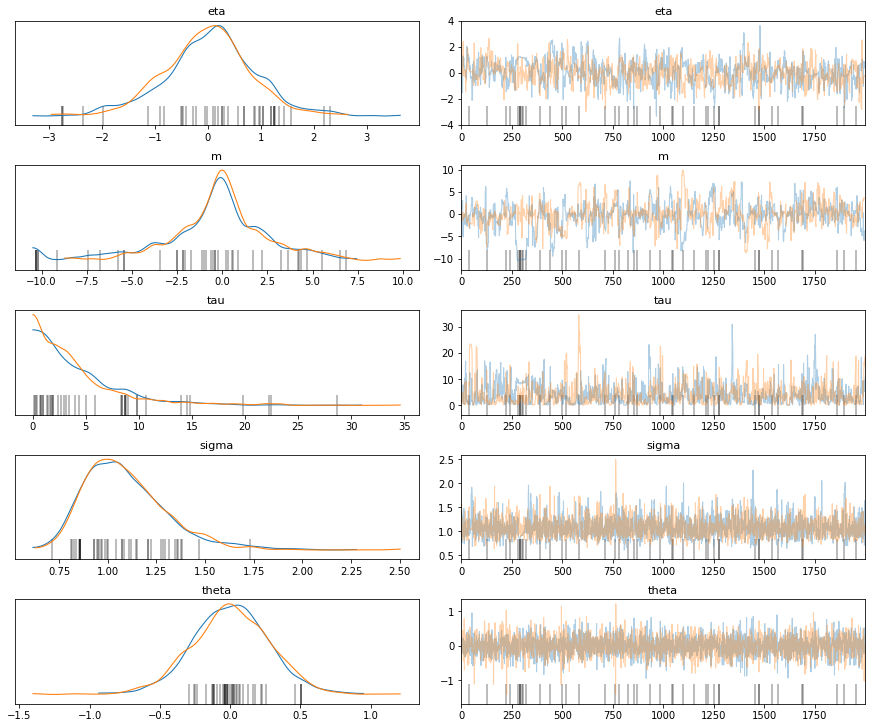

In [51]:
az.plot_trace(trace_hm)

In [32]:
vari = theano.shared(chem_var.loc[:,'x1':'x3_2'].values)
var_idx = OrdinalEncoder(dtype = np.int64).fit_transform(chem_var[['x1']])

with pm.Model() as hierarch_model:
      # Hyperparameters
    # eta = pm.Normal('eta', 0, 1)
    # tau = pm.HalfCauchy('tau', 5)
    # m = pm.Normal('m', mu = 0, sigma = 5)

    # theta = pm.Deterministic('theta', m + tau * eta)

    # y_obs = pm.Normal('y_obs', mu = theta, sigma = vari, observed = chem_var.y)


  # parameter proirs
  alpha = pm.Normal('alpha', 0, .2) # for some reason I set the alpha to 1 and it was taking much longer than I needed, hopefully .2 works
  sigma = pm.Exponential('sigma', 1)
  tau_delta = pm.Flat('tau_delta')

  constant = var_idx
  data = theano.shared(chem_var.loc[:, 'x1':'x3_2'].values)
  beta = pm.Normal('beta', 0, .5, shape=9)
  delta = pm.Normal('delta', 0, tau_delta)

# Model equation and observation
  mu = pm.Deterministic('mu', alpha + tt.dot(data, beta))
  y = pm.Normal('y', mu, sigma, observed=chem_var.y) 

In [40]:
# with hierarch_model:
#   trace_hm = pm.sample(2000,  init='advi', cores = 2, tune=4000, target_accept = .97)
#   trace_hm_sum = pm.summary(trace_2)

# trace_hm_sum

In [41]:

def logp_ab(value):
    '''Transformation for the hyperprior. Theano tensor magic.'''
    return tt.log(tt.pow(tt.sum(value), -5/2))

with pm.Model() as hierarchical_model:
    # Uninformative prior for alpha and beta
    ab = pm.HalfFlat('ab', shape=9)
    p = pm.Potential('p(a, b)', logp_ab(ab))

    # Distributions for theta
    theta = pm.Beta('theta', alpha=ab[0], beta=ab[1], shape = 9)
    
    # Data distribution
    y_obs = pm.Normal('y_obs', p = theta, observed = chem_var.y, n=chem_var.sum(axis=1))
    
    # trace = pm.sample(2000, target_accept = 0.95)

TypeError: ignored

In [14]:
var_idx = OrdinalEncoder(dtype = np.int64).fit_transform(chem_var[['x1']])

with pm.Model() as hierarchical_mdl:
  alpha = pm.Normal('alpha', .2) #mean
  sigma = pm.HalfCauchy('sigma', 1) #sd
  tau_delta = pm.Flat('tau_delta')

  temp = theano.shared(var_idx)
  data = theano.shared(chem_var.loc[:, 'x1':'x3_2'].values)
  beta = pm.Normal('beta', 0, .5, shape=9)
  delta = pm.Normal('delta', 0, tau_delta, shape = 9)

  # mu = pm.Deterministic('mu', alpha + tt.dot(data, beta) + tt.dot(temp, delta)) #chem_var.x1, x1 is the constant variable in the dataset, it looks at 3 different types of temperatures
  mu = pm.Deterministic('mu', alpha + tt.dot(data, beta) + delta[0]*chem_var.x1 + delta[1]*chem_var.x2 + delta[2]*chem_var.x3 + delta[3]*chem_var.x1x2 +  delta[4]*chem_var.x1x3 + delta[5]*chem_var.x2x3 + delta[6]*chem_var.x1_2 + delta[7]*chem_var.x2_2 + delta[8]*chem_var.x3_2)


  y = pm.Normal('y', mu, sigma, observed = chem_var.y)


In [71]:
# with hierarchical_mdl:
#     trace_2 = pm.sample(2000,  init='advi', cores = 2, tune=4000, target_accept = .95)
#     trace_2_sum = pm.summary(trace_2)

# trace_2_sum

##use summary table to get the t-statistic??

In [ ]:
pm.traceplot(trace_2)

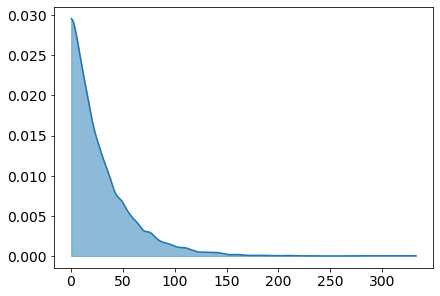

In [ ]:
with hierarchical_mdl:
    ν = pm.Exponential('ν_minus_one', 1/29.) + 1

pm.kdeplot(np.random.exponential(30, size=10000), fill_kwargs={'alpha': 0.5});

In [72]:
# with hierarchical_mdl:
#   distb_mean = pm.Exponential('distb_mean', 1/29.) + 1
#   t_test = pm.StudentT('t_test', nu = ν_distb_mean, mu = trace_2_sum['mcse_mean'], lam = trace_2_sum['mcse_sd'])
# t_test

In [ ]:
def pairplot_divergence(trace_2, ax=None, divergence=True, color='C3', divergence_color='C2'):
    theta = trace_2.get_values(varname='theta', combine=True)[:, 0]
    logtau = trace_2.get_values(varname='tau_log__', combine=True)
    if not ax:
        _, ax = plt.subplots(1, 1, figsize=(10, 5))
    ax.plot(theta, logtau, 'o', color=color, alpha=.5)
    if divergence:
        divergent = trace_2['diverging']
        ax.plot(theta[divergent], logtau[divergent], 'o', color=divergence_color)
    ax.set_xlabel('theta[0]')
    ax.set_ylabel('log(tau)')
    ax.set_title('scatter plot between log(tau) and theta[0]');
    return ax

pairplot_divergence(trace_2)

In [ ]:
for i in chem_var.y:
  conversion = np.tile(t


NameError: ignored

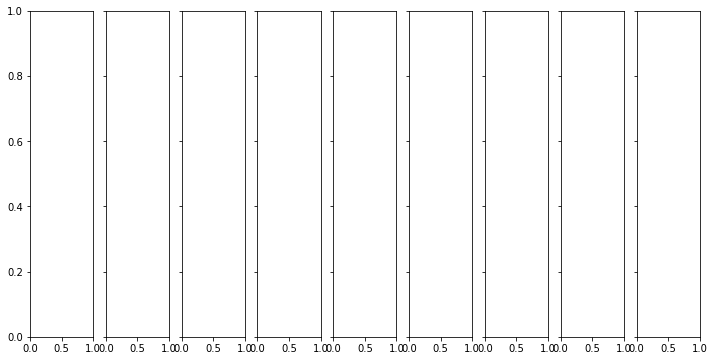

In [ ]:
selection = ['x1', 'x2', 'x3','x1x2','x1x3','x2x3','x1_2','x2_3','x3_2']
fig, axis = plt.subplots(1, 9, figsize=(12, 6), sharey=True, sharex=True)
axis = axis.ravel()
for i, c in enumerate(selection):
    t_data = chem_var[chem_var.x1 == t]
    t_data = t_data.reset_index(drop=True)
    t_index = np.where(x1 == t)[0][0]
    z = list(t_data['x1'])[0]

    xvals = np.linspace(-0.2, 1.2)
    for a_val, b_val in zip(trace_1['a'][:, t_index], trace_1['b'][:, t_index]):
        axis[i].plot(xvals, a_val + b_val * xvals, 'b', alpha=.1)
    axis[i].plot(xvals, trace_1['a'][:, c_index].mean() + trace_1['b'][:, c_index].mean() * xvals,
                 'b', alpha=1, lw=2., label='individual')
    for a_val, b_val in zip(trace_2['a'][z], trace_2['b'][z]):
        axis[i].plot(xvals, a_val + b_val * xvals, 'g', alpha=.1)
    axis[i].plot(xvals, trace_2['a'][z].mean() + trace_2['b'][z].mean() * xvals,
                 'g', alpha=1, lw=2., label='hierarchical')
    axis[i].scatter(t_data.floor + np.random.randn(len(t_data))*0.01, t_data.y,
                    alpha=1, color='k', marker='.', s=80, label='original data')
    axis[i].set_xticks([0, 1])
    axis[i].set_xticklabels(['basement', 'no basement'])
    axis[i].set_ylim(-1, 4)
    axis[i].set_title(c)
    if not i % 3:
        axis[i].legend()
        axis[i].set_ylabel('log radon level')

In [9]:
# with pm.Model() as modelT:
#     sigma = pm.HalfCauchy('sigma', 5)
#     # mu = pm.Deterministic('mu', alpha + b[0]*chem_var.x1 + b[1]*chem_var.x2 + b[2]*chem_var.x3 + b[3]*chem_var.x1x2 +
#                           # b[4]*chem_var.x1x3 + b[5]*chem_var.x2x3 + b[6]*chem_var.x1_2 + b[7]*chem_var.x2_2 + b[8]*chem_var.x3_2)
#     m = pm.Normal('m', 0, 16)
#     nu = pm.HalfCauchy('nu', 5)
#     y_obs = pm.StudentT('y_obs', nu = nu, mu = mu, sigma = sigma, observed = chem_var.y)
    
#     trace_T = pm.sample(2000,  init='advi', cores = 2, tune=2000, target_accept = .95)
#     replicates = pm.sample_posterior_predictive(trace_T)
#     T_sum = pm.summary(trace_T)

# T_sum


# with pm.Model() as ord_modelT:
#   # parameter proirs
#   alpha = pm.Normal('alpha', 0, .2) # for some reason I set the alpha to 1 and it was taking much longer than I needed, hopefully .2 works
#   sigma = pm.Exponential('sigma', 1)
#   # nu = pm.Exponential('nu', 1./10, testval = 5.)
#   nu = pm.HalfCauchy('nu', 5)
#   # means = pm.StudentT('means', nu = nu, mu = hyper_mean, sd = hyper_sigma, shape = n_individuals)
#   mu = pm.Deterministic('mu', alpha + b[0]*chem_var.x1 + b[1]*chem_var.x2 + b[2]*chem_var.x3 + b[3]*chem_var.x1x2 +  b[4]*chem_var.x1x3 + b[5]*chem_var.x2x3 + b[6]*chem_var.x1_2 + b[7]*chem_var.x2_2 + b[8]*chem_var.x3_2)
#   means = pm.StudentT('means', nu, mu,sigma) #use for each explanatory variable - I had this at 1 and it was KILLING my sampling!! 

#       # means = pm.StudentT('means', nu = nu, mu = hyper_mean, sd = hyper_sigma, shape = n_individuals)
# # Model equation and observation
#   # mu = pm.Deterministic('mu', alpha + b[0]*chem_var.x1 + b[1]*chem_var.x2 + b[2]*chem_var.x3 + b[3]*chem_var.x1x2 +  b[4]*chem_var.x1x3 + b[5]*chem_var.x2x3 + b[6]*chem_var.x1_2 + b[7]*chem_var.x2_2 + b[8]*chem_var.x3_2)
#   y = pm.Normal('y', mu = means, sigma = sigma, observed=chem_var.y) #chem_var.y

In [ ]:
# var_ = pd.DataFrame(dict(value=np.r_[chem_var.x1, x2, x3, x1x2, x1x3, x2x3, x1_2, x2_2, x3_2], group=np.r_[['x1']*len(x1), ['placebo']*len(placebo)]))

# I know there's an easier way to do this but I am at a loss at the moment.


#calculate mean for each explanatory vairable

μ_m = vari.mean()
μ_s = vari.std() * 2

with pm.Model() as model:
    group1_mean = pm.Normal('group1_mean', mu=μ_m, sd=μ_s)
    group2_mean = pm.Normal('group2_mean', mu=μ_m, sd=μ_s)
    group3_mean = pm.Normal('group3_mean', mu=μ_m, sd=μ_s)
    group4_mean = pm.Normal('group4_mean', mu=μ_m, sd=μ_s)
    group5_mean = pm.Normal('group5_mean', mu=μ_m, sd=μ_s)
    group6_mean = pm.Normal('group6_mean', mu=μ_m, sd=μ_s)
    group7_mean = pm.Normal('group7_mean', mu=μ_m, sd=μ_s)
    group8_mean = pm.Normal('group8_mean', mu=μ_m, sd=μ_s)
    group9_mean = pm.Normal('group9_mean', mu=μ_m, sd=μ_s)

In [ ]:
σ_low = 1
σ_high = 10

#calculate std for each explanatory vairable with a uniform prior of (1,10)


with model:
    group1_std = pm.Uniform('group1_std', lower=σ_low, upper=σ_high)
    group2_std = pm.Uniform('group2_std', lower=σ_low, upper=σ_high)
    group3_std = pm.Uniform('group3_std', lower=σ_low, upper=σ_high)
    group4_std = pm.Uniform('group4_std', lower=σ_low, upper=σ_high)
    group5_std = pm.Uniform('group5_std', lower=σ_low, upper=σ_high)
    group6_std = pm.Uniform('group6_std', lower=σ_low, upper=σ_high)
    group7_std = pm.Uniform('group7_std', lower=σ_low, upper=σ_high)
    group8_std = pm.Uniform('group8_std', lower=σ_low, upper=σ_high)
    group9_std = pm.Uniform('group9_std', lower=σ_low, upper=σ_high)


In [ ]:
#transform the std to work with the precison terms to specify our likelihoods

with model:
    λ1 = group1_std**-2
    λ2 = group2_std**-2
    λ3 = group3_std**-2
    λ4 = group4_std**-2
    λ5 = group5_std**-2
    λ6 = group6_std**-2
    λ7 = group7_std**-2
    λ8 = group8_std**-2
    λ9 = group9_std**-2

    group1 = pm.StudentT('group1', nu=ν, mu=group1_mean, lam=λ1, observed=chem_var.x1)
    group2 = pm.StudentT('group2', nu=ν, mu=group2_mean, lam=λ2, observed=chem_var.x2)
    group3 = pm.StudentT('group3', nu=ν, mu=group3_mean, lam=λ1, observed=chem_var.x3)
    group4 = pm.StudentT('group4', nu=ν, mu=group4_mean, lam=λ4, observed=chem_var.x1x2)
    group5 = pm.StudentT('group5', nu=ν, mu=group5_mean, lam=λ5, observed=chem_var.x1x3)
    group6 = pm.StudentT('group6', nu=ν, mu=group6_mean, lam=λ6, observed=chem_var.x2x3)
    group7 = pm.StudentT('group7', nu=ν, mu=group7_mean, lam=λ7, observed=chem_var.x1_2)
    group8 = pm.StudentT('group8', nu=ν, mu=group8_mean, lam=λ8, observed=chem_var.x2_2)
    group9 = pm.StudentT('group9', nu=ν, mu=group9_mean, lam=λ9, observed=chem_var.x3_2)



Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [ν_minus_one, group9_std, group8_std, group7_std, group6_std, group5_std, group4_std, group3_std, group2_std, group1_std, group9_mean, group8_mean, group7_mean, group6_mean, group5_mean, group4_mean, group3_mean, group2_mean, group1_mean]


Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 470 seconds.
The acceptance probability does not match the target. It is 0.26280840882887546, but should be close to 0.8. Try to increase the number of tuning steps.
There were 43 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 7.424164075851339e-58, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


In [ ]:
with model:
    trace = pm.sample(2000)
    trace_sum = pm.summary(trace)

/usr/local/lib/python3.6/dist-packages/arviz/data/io_pymc3.py:91: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


KeyboardInterrupt: ignored

In [ ]:
pm.plot_posterior(trace)

### Extra

In [ ]:
# Replicate the posterior predictive check from BDA section 15.2

def make_pooled_ppc(trace, data):
    # Sample from the posterior predictive distribution for each year
    with logistic_model:
    ppc = pm.sample_posterior_predictive(trace_1, var_names=["y", 'alpha']
    )

    rmse= np.array([np.average()])
    # reps_dict = {}
    # for year in np.arange(1948, 1992, 4):
    #     with setup_pooled_model(train[train.year == year]) as test_model: 
    #         ppc = pm.sample_posterior_predictive(train_trace)
    #         reps_dict[year] = ppc['y']
    
    # Calculate residuals: replications vs. observations
    # rep_resid = {}
    # pred_resid = {}
    # nrep = reps_dict[1948].shape[0]
    # for year in np.arange(1948, 1992, 4):
    #     thisyear_dvote = np.tile(train[train.year == year]['dvote'], (2000,1))
    #     rep_resid[year] = reps_dict[year][:, :] - train_trace['mu'][:,train.year == year]
    #     pred_resid[year] = thisyear_dvote - train_trace['mu'][:,train.year == year]
    
    # Mean squared residuals
    sq_rep_resid_array = np.array([np.average(rep_resid[year], axis = 1) ** 2 for year in np.arange(1948, 1992, 4)])
    sq_pred_resid_array = np.array([np.average(pred_resid[year], axis = 1) ** 2 for year in np.arange(1948, 1992, 4)])
    
    # Final test statistics
    trep = np.sqrt(np.sum(sq_rep_resid_array, axis = 0))
    t = np.sqrt(np.sum(sq_pred_resid_array, axis = 0))
    
    #Make the plot
    plt.plot(t, trep, '.', color = 'blue', alpha = 0.3)
    plt.plot(np.linspace(0, 0.05, 5), np.linspace(0, 0.05, 5), color = 'red')
    plt.show()

In [ ]:
with pm.Model() as model_1:

    # Independent parameters for each county
    a = pm.Normal('a', 0, sigma=100, shape=n_chem)
    b = pm.Normal('b', 0, sigma=100, shape=n_chem)

    # Model error
    eps = pm.HalfCauchy('eps', 5)

    # Model prediction of radon level
    # a[county_idx] translates to a[0, 0, 0, 1, 1, ...],
    # we thus link multiple household measures of a county
    # to its coefficients.
    chem_est = a[chem_idx] + b[chem_idx]*chemical.y.values

    # Data likelihood
    y = pm.Normal('y', chem_est, sigma=eps, observed=chemical.y)

In [ ]:
# with model_1:
#     trace_1 = pm.sample(2000)
#     trace_1_sum = pm.summary(trace_1)

# trace_1_sum

In [ ]:
with pm.Model() as unpooled_model:

    # Independent parameters for each block
    ba = pm.Normal('ba', 0, sigma=100, shape=n_pen)
    bb = pm.Normal('bb', 0, sigma=100, shape=n_pen)
    bc = pm.Normal('bc', 0, sigma=100, shape=n_pen)
    bd = pm.Normal('bd', 0, sigma=100, shape=n_pen)


    # Model error
    eps = pm.HalfCauchy('eps', 5)

    # Model prediction of treatments level
    # a[county_idx] translates to a[0, 0, 0, 1, 1, ...],
    # we thus link multiple household measures of a county to its coefficients.
    treat_est = ba[pen_idx] + bb[pen_idx] + bc[pen_idx]*penecillin.D.values

    # Data likelihood
    y = pm.Normal('y', treat_est, sigma=eps, observed=penecillin.mean)



# Fully pooled; simple logistic regression

# with pm.Model() as log_model:
#     a = pm.Normal('a', 0, 2, shape = n_pen)
#     b = pm.Normal('b', 0, 1, shape = n_pen)
#     sigma = pm.HalfCauchy('sigma', 5)
#     mu = pm.math.invlogit(a + b[pen_idx] * pen_idx)
#     score = pm.Normal('score', mu=mu, observed = "penecillin.D, penecillin.C, penecillin.B",)

    trace_simple = pm.sample(2000, target_accept = 0.95, tune = 1000)
    summary_simple = pm.summary(trace_simple)

TypeError: ignored